In [13]:
import tensorflow as tf
from time import time
import numpy
import pickle
import pandas
import datetime
import sys
sys.path.append('../libs')
import pipeline, conv_model, data_util, prepare_data

In [23]:
tf.distribute.MirroredStrategy?

In [25]:
! nvidia-smi

Thu Oct 10 04:49:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  On   | 00000000:05:00.0 Off |                  N/A |
| 24%   63C    P2   113W / 250W |  11854MiB / 12212MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  On   | 00000000:08:00.0 Off |                  N/A |
| 32%   72C    P2   121W / 250W |  11850MiB / 12212MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
H = {
    'require_all_sigs': False,
    'layer_count_a': 3,
    'layer_count_b': 7,
    'kernel_size_a': 16,
    'stride_a': 4,
    'kernel_size_b': 4,
    'window_size': 512,
    'windows_per_chunk': 5,
    'activation': 'relu',
    'dropout': 0.2,
    'filter_count': 256,
    'dense_units': 128,
    'batch_size': 256,
    'batch_buffer_size': 4,
    'optimizer': {
        'name': 'adam',
        'args': {
            'learning_rate': 3e-4,
            'beta_1': 0.9,
            'beta_2': 0.999,
            'amsgrad': True,
        }
    }
}

In [7]:
%%time

tf.debugging.set_log_device_placement(True)
tf.random.set_seed(7)
numpy.random.seed(7)

metadata, sig_data = data_util.load_initial_data(H['require_all_sigs'])
data_util.describe_data_size(metadata)
print(len(metadata))

345 GB,  48 years
79674
CPU times: user 23.4 s, sys: 3.78 s, total: 27.2 s
Wall time: 27.3 s


In [8]:
epoch = data_util.sample_epoch(H, metadata, sig_data)
data = pipeline.build(H, epoch)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BroadcastTo in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/t

Executing op ReadFile in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParseTensor in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherNd in

<IPython.core.display.Javascript object>


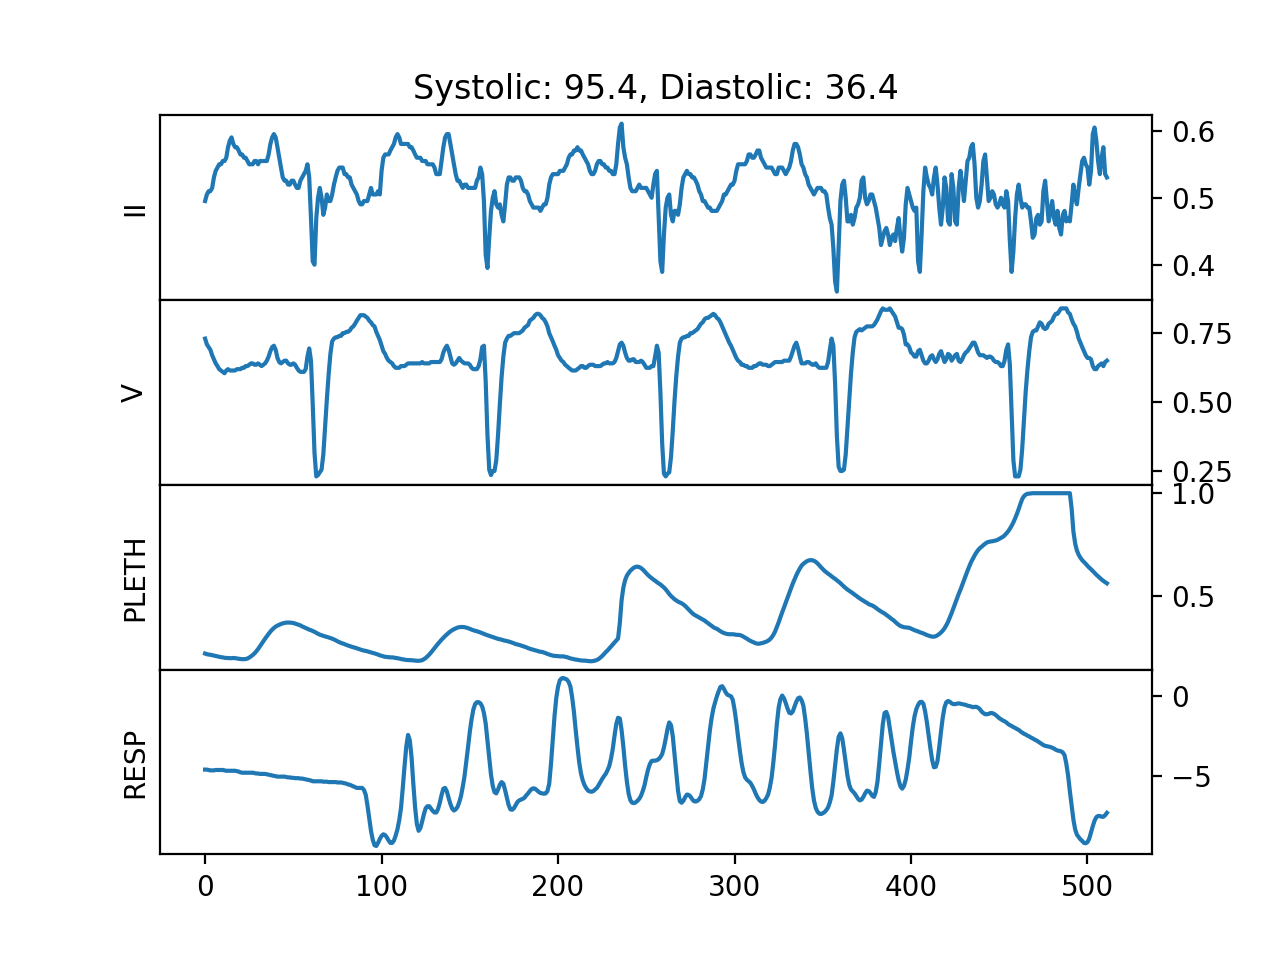

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0


In [10]:
%matplotlib notebook
from matplotlib import pyplot

def plot_waves(x):
    pyplot.subplots_adjust(wspace=0, hspace=0)
    for i, sig in enumerate(prepare_data.INPUT_SIGS):
        ax = pyplot.subplot(len(prepare_data.INPUT_SIGS), 1, i + 1)
        ax.plot(x[:, i])
        ax.set_ylabel(sig)
        ax.yaxis.tick_right()

def plot_batch_example(x, y):
    fig = pyplot.figure()
    plot_waves(x)
    fig.axes[0].set_title('Systolic: %.1f, Diastolic: %.1f' % tuple(y.numpy()))
    
# i, j = 4, 0

# window_index_matrix = pipeline.get_window_index_matrix(H)

# windows = pipeline.get_windows(
#     H['window_size'],
#     window_index_matrix,
#     tf.constant(epoch['chunk_paths'][i],    dtype='string'),
#     tf.constant(epoch['sig_indices'][i],    dtype='int32'),
#     tf.constant(epoch['window_indices'][i], dtype='int32'),
#     tf.constant(epoch['baselines'][i],      dtype='int32'),
#     tf.constant(epoch['gains'][i],          dtype='float32'),   
# )

data_iter = iter(data)
x, y = next(data_iter)

x, y = list(windows)[j]
plot_batch_example(x, y)